# CDLOF pyOD

In [16]:
!pip install pyod

In [17]:
cd ./drive/MyDrive/InControl/

[Errno 2] No such file or directory: './drive/MyDrive/InControl/'
/content/drive/MyDrive/InControl


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import numpy as np

# cnx = sqlite3.connect('YUGRES_all.sqlite')
# print(cnx.cursor)
# test_df = pd.read_sql_query("SELECT * FROM 'data'", cnx, parse_dates=True,index_col = 'timestamp')
test_df = pd.read_csv('data.csv', index_col = 'timestamp', parse_dates=True, squeeze=True)
test_df = test_df[test_df['20MBY10CE901_XQ01']>195]
# time_ = pd.to_datetime(test_df['timestamp'])
# # Создаем список названий столбцов, которые начинаются с "20"
selected_columns = [col for col in test_df.columns if col.startswith("20")]
# # Создаем новый DataFrame, содержащий только выбранные столбцы
df_selected_test = test_df[selected_columns]
# df_selected_test.index = time_

<ipython-input-18-4e1f92c1e301>:11: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  test_df = pd.read_csv('data.csv', index_col = 'timestamp', parse_dates=True, squeeze=True)


In [19]:
df_selected_test.fillna(method='ffill', inplace=True)

# Масштабирование данных (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected_test)

<ipython-input-19-6f254272bed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_test.fillna(method='ffill', inplace=True)


In [20]:
from pyod.models.cblof import CBLOF
clf_name = 'CBLOF'
clf = CBLOF(random_state=42)
clf.fit(scaled_data)

# get outlier scores
y_train_scores = clf.decision_scores_ # raw outlier scores on the train data
# y_test_scores = clf.decision_function(df)  # predict raw outlier scores on test
y_train_pred = clf.labels_
print(y_train_scores)
print(y_train_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1.72718246 1.73742745 1.71230676 ... 1.00153896 1.02412716 1.02703459]
[0 0 0 ... 0 0 0]


In [21]:
import scipy
def scaler_loss(target_value, scaler_name, range_loss = 100):
            if scaler_name == 'cdf':
                hist = np.histogram(target_value, bins=range_loss)
                # logger.debug(target_value)
                scaler_loss = scipy.stats.rv_histogram(hist)
                # logger.debug(hist)
                target_value = scaler_loss.cdf(target_value)*range_loss
                scaler_loss = hist
            elif scaler_name == 'minmax':
                scaler_loss = MinMaxScaler(feature_range=(0, range_loss))
                loss_2d = np.reshape(target_value, (-1,1))
                scaler_loss.fit(loss_2d)
                target_value = scaler_loss.transform(loss_2d)
            return target_value, scaler_loss

In [22]:
loss = scaler_loss(y_train_scores,'cdf')

In [23]:
df_loss = pd.DataFrame()
df_loss['loss'] = y_train_scores
target_value, scaler_loss = scaler_loss(df_loss['loss'],'cdf')
print(target_value)



[86.64700378 86.81218259 86.38674578 ... 34.24204161 37.29153924
 37.68405368]


In [24]:
df_target = pd.DataFrame()
df_target['target_value'] = target_value
df_target.index = df_selected_test.index
print(df_target)
df_target.to_csv('pyOD_CDLOF.csv')

                     target_value
timestamp                        
2017-01-01 00:00:00     86.647004
2017-01-01 00:05:00     86.812183
2017-01-01 00:10:00     86.386746
2017-01-01 00:15:00     86.269305
2017-01-01 00:20:00     86.672471
...                           ...
2019-07-23 20:40:00     35.171611
2019-07-23 20:45:00     32.615878
2019-07-23 20:50:00     34.242042
2019-07-23 20:55:00     37.291539
2019-07-23 21:00:00     37.684054

[204186 rows x 1 columns]


In [25]:
df = pd.read_csv('pyOD_CDLOF.csv')

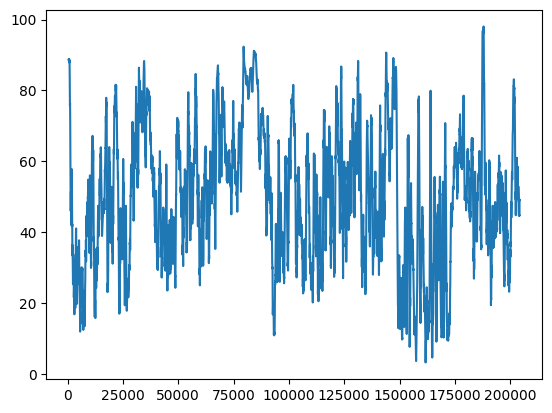

In [26]:
window_size = 512
df['target_mean'] = df['target_value'].rolling(window=window_size).mean()
plt.plot(df['target_mean'])

In [27]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [28]:
import pandas as pd

data_to_remove = {
    'Начало': ['2017-01-13 16:05:00', '2017-01-24 13:35:00', '2017-12-22 00:00:00',
               '2017-12-22 00:00:00', '2017-03-05 00:00:00', '2017-03-03 00:00:00',
               '2017-12-22 18:10:00', '2019-05-25 01:10:00', '2017-07-06 00:00:00',
               '2019-05-26 00:00:00', '2017-03-03 00:00:00'],
    'Конец': ['2017-01-21 08:50:00', '2017-02-06 05:00:00', '2018-02-19 00:00:00',
             '2017-12-22 23:55:00', '2017-03-05 23:55:00', '2017-03-03 23:55:00',
             '2018-02-20 20:55:00', '2019-05-28 14:45:00', '2017-07-06 23:55:00',
             '2019-05-26 23:55:00', '2017-03-03 23:55:00']
}

# Преобразуем даты в формат Timestamp
date_tuples = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in zip(data_to_remove['Начало'], data_to_remove['Конец'])]

print(date_tuples)

[(Timestamp('2017-01-13 16:05:00'), Timestamp('2017-01-21 08:50:00')), (Timestamp('2017-01-24 13:35:00'), Timestamp('2017-02-06 05:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2018-02-19 00:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2017-12-22 23:55:00')), (Timestamp('2017-03-05 00:00:00'), Timestamp('2017-03-05 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00')), (Timestamp('2017-12-22 18:10:00'), Timestamp('2018-02-20 20:55:00')), (Timestamp('2019-05-25 01:10:00'), Timestamp('2019-05-28 14:45:00')), (Timestamp('2017-07-06 00:00:00'), Timestamp('2017-07-06 23:55:00')), (Timestamp('2019-05-26 00:00:00'), Timestamp('2019-05-26 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00'))]


In [29]:
import numpy as np
import pandas as pd

# Замените 'df' на вашу собственную переменную DataFrame
# и 'timestamp' на имя столбца с временными метками,
# 'value' на имя столбца со значениями

# Рассчитываем порог
short_threshold = 85

# Создаем список, чтобы хранить интервалы
intervals = []

# Инициализируем переменные для текущего интервала
current_interval_start = None
current_interval_end = None

# Проходимся по всем строкам DataFrame
for index, row in df.iterrows():
    timestamp = row['timestamp']  # Предполагается, что столбец 'timestamp' содержит временные метки
    # Если значение выше порога, начинаем новый интервал
    if row['target_mean'] > short_threshold:
        if current_interval_start is None:
            current_interval_start = timestamp
        current_interval_end = timestamp
    else:
        # Если значение ниже порога, закрываем текущий интервал
        if current_interval_start is not None:
            # Проверяем длительность интервала
            if current_interval_end - current_interval_start > pd.Timedelta(seconds=600):
                intervals.append((current_interval_start, current_interval_end))
            # Сбрасываем переменные текущего интервала
            current_interval_start = None
            current_interval_end = None

# Проверяем последний интервал после завершения цикла
if current_interval_start is not None:
    if current_interval_end - current_interval_start > pd.Timedelta(seconds=600):
        intervals.append((current_interval_start, current_interval_end))


                 timestamp  target_value  target_mean
511    2017-01-02 18:35:00     87.937604    88.686275
512    2017-01-02 18:40:00     87.929016    88.688779
513    2017-01-02 18:45:00     88.267132    88.691621
514    2017-01-02 18:50:00     88.334072    88.695424
515    2017-01-02 18:55:00     88.634740    88.700044
...                    ...           ...          ...
188090 2019-05-28 21:30:00     82.066090    85.390255
188091 2019-05-28 21:35:00     78.702953    85.349432
188092 2019-05-28 21:40:00     63.289018    85.278564
188093 2019-05-28 21:45:00     49.833802    85.181351
188094 2019-05-28 21:50:00     40.960961    85.066859

[6125 rows x 3 columns]
                timestamp  target_value  target_mean
2772  2017-01-13 16:05:00      6.857856    27.351555
2773  2017-01-13 16:10:00      6.388300    27.182393
2774  2017-01-13 16:15:00      6.030790    27.014957
2775  2017-01-13 16:20:00      3.233211    26.843889
2776  2017-01-13 16:25:00      2.355528    26.673691
...      

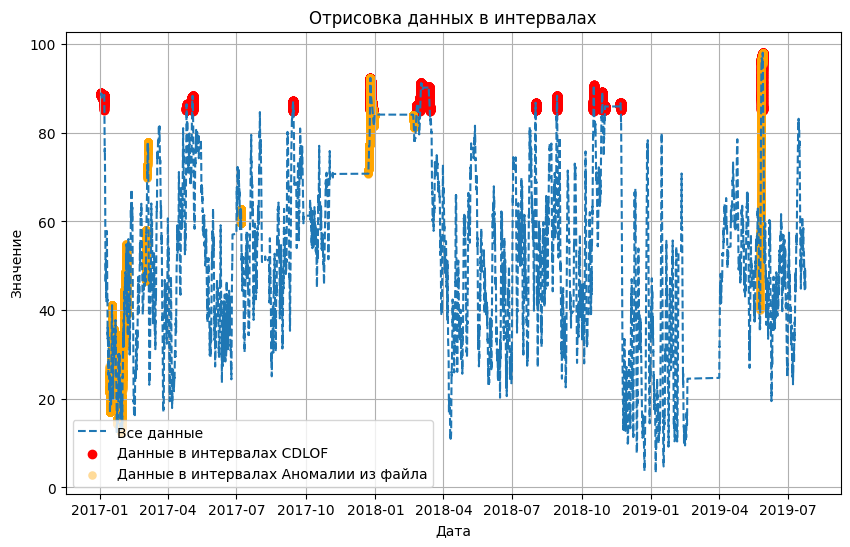

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


df['timestamp'] = pd.to_datetime(df['timestamp'])
# Определите интервалы
intervals = intervals
intervals_an = date_tuples

# Фильтруем DataFrame, чтобы получить только строки, которые находятся в интервалах
filtered_df = pd.DataFrame()
filtered_df_an = pd.DataFrame()

for interval in intervals:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df = pd.concat([filtered_df, interval_df])
print(filtered_df)
for interval in intervals_an:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df_an = pd.concat([filtered_df_an, interval_df])
print(filtered_df_an)

# Отрисовываем полученные данные
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['target_mean'], label='Все данные', linestyle='--')
plt.scatter(filtered_df['timestamp'], filtered_df['target_mean'], color='red', label='Данные в интервалах CDLOF')
plt.scatter(filtered_df_an['timestamp'], filtered_df_an['target_mean'], color='orange', label='Данные в интервалах Аномалии из файла', alpha = 0.4,linewidths=0.1)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Отрисовка данных в интервалах')
plt.grid(True)
plt.show()

In [ ]:
import json
from datetime import datetime


# Преобразование интервалов в список словарей
interval_dicts = []

for start, end in intervals:
    interval_dict = {
        "start": str(start),
        "end": str(end),
        "duration_hours": (end - start).total_seconds() / 3600
    }
    interval_dicts.append(interval_dict)

# Преобразование в JSON
json_data = json.dumps(interval_dicts, indent=4)

# Сохранение JSON в файл
with open("intervals_CDLOF.json", "w") as json_file:
    json_file.write(json_data)